# ZNE with indirect-control VQE (noisy time-evolution gates)
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse field Ising Hamiltonian.
- Ansatz time-evolution: XY



## (1) Import and setup

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 10

# Others
plot_titles = {
    "xy": "XY ansatz",
    "heisenberg": "Heisenberg ansatz",
    "ising": "Ising ansatz"
}

plot_export_names = {
    "xy": "xy_ansatz_noise_free_tevo.eps",
    "heisenberg": "heisenberg_ansatz_noise_free_tevo.eps",
    "ising": "ising_ansatz_noise_free_tevo.eps",
    "compiled": "compiled.eps",
    "heisenberg_further1": "heisenberg_ansatz_further_ric3.eps"
}

plot_colors = [
    "darkred",
    "darkgreen",
    "darkblue",
    "darkmagenta",
    "darkcyan",
    "magenta",
    "green",
    "goldenrod",
    "black",
    "orange",
    "purple"
    ]

## (2) Loading the experimental data from JSON files

The raw experimenal data are availabe at `data\` folder

In [3]:
# Define the paths to the subfolders and the additional JSON file
base_path = "data"
# Define the subfolders you want to load (e.g., "xy", "heisenberg", etc.)
subfolders = ["xy"]  # adjust as needed
various_param_file = os.path.join(base_path, "variousParams.json")
# Initialize a dictionary to store the experimental data
experimental_data: dict = {}

for subfolder in subfolders:
    folder_path = os.path.join(base_path, subfolder)
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} not found.")
        continue
    json_files = [f for f in os.listdir(folder_path) if f.endswith(".json") and "zne" in f.lower()]
    zne_files = []
    for json_file in json_files:
        file_path = os.path.join(folder_path, json_file)
        with open(file_path, "r") as f:
            data = json.load(f)
            zne_files.append(data)
    experimental_data[subfolder] = {
        "zne": zne_files
    }

# Print a summary of loaded files
for subfolder in subfolders:
    count = len(experimental_data.get(subfolder, {}).get("zne", []))
    print(f"Loaded {count} ZNE JSON files from '{subfolder}'")

# Load the variousParam.json file
if os.path.exists(various_param_file):
    with open(various_param_file, "r") as f:
        various_param = json.load(f)
        print("variousParam.json loaded successgully!")
else:
    print(f"File {various_param_file} not found.")

Loaded 10 ZNE JSON files from 'xy'
variousParam.json loaded successgully!


In [4]:
if experimental_data:
    df = pd.json_normalize(experimental_data["xy"]["zne"])
print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))

+--------------+------------------+----------------+----------------------------------+-----------------------------+------------------------------+---------------------------+-------------------------+-------------------------------------+-------------------------------------+------------------------------------+-----------------------+-------------------------+----------------------------+---------------------------------------+---------------------------------------+--------------------------------------+--------------------------------+--------------------------------+------------------------+----------------------------------+-------------------------------------+--------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## (3) Extracting data


Redundant circuit

<img src="../../figures/quantum_cicuit_xyiss.jpg" alt="std_vs_redun_circuit" width="800"/>

### (B) VQE estimations (noise is on)

The noise level ($\lambda$) is defined as 
$$\lambda = n_R + 2 n_{CZ} + N n_T + n_Y$$

where $nR, n_{CZ}, n_T, $ and $nY$ are proportinal to number of *noisy* rotation gates, two-qubit $CZ$ gate, the time-evolution gates, and Y gates. For the above circuit in the standard circuit (i.e. unboosted noise) noise level is $13$ while in the redundant circuit (i.e. boosted noise) noise level is $43$.

In [5]:
exact_sol: float = -8.566772233505624
print(f"Exact solution: {exact_sol}")

Exact solution: -8.566772233505624


### (B) VQE estimations (noise is on)

The noise level ($\lambda$) is defined as 
$$\lambda = n_R + 2 n_{CZ} + N n_T + n_Y$$

where $nR, n_{CZ}, n_T, $ and $nY$ are proportinal to number of *noisy* rotation gates, two-qubit $CZ$ gate, the time-evolution gates, and Y gates. 

In [6]:
noise_levels: int=[13, 47]
extrapolated_noise: int = 0

In [7]:
# Extract sampled data arrays for both XY and Heisenberg ansätze
xy_sampled_data = [entry["output"]["zne_values"]["sampled data"] for entry in experimental_data["xy"]["zne"]]


# Compute noisy VQE statistics
noisy_vqe_vals: dict = {
    "xy": {
        "mean": [
            np.mean([sample[0][4] for sample in xy_sampled_data]),  # Unboosted (noise level 6)
            np.mean([sample[1][4] for sample in xy_sampled_data]),  # Boosted (noise level 18)
        ],
        "std": [
            np.std([sample[0][4] for sample in xy_sampled_data]),   # Unboosted
            np.std([sample[1][4] for sample in xy_sampled_data]),   # Boosted
        ],
    }
}
# Lets print the values as well
# Labels
headers = ["Ansatz", "Noise Level", "Mean", "Std Dev"]

# Data rows
rows = [
    ["xy", "Unboosted (noise 13)", noisy_vqe_vals["xy"]["mean"][0], noisy_vqe_vals["xy"]["std"][0]],
    ["xy", "Boosted (noise 63)",  noisy_vqe_vals["xy"]["mean"][1], noisy_vqe_vals["xy"]["std"][1]],
]

# Print table
print(tabulate(rows, headers=headers, floatfmt=".6f", tablefmt="grid"))

+----------+----------------------+-----------+-----------+
| Ansatz   | Noise Level          |      Mean |   Std Dev |
+==========+======================+===========+===========+
| xy       | Unboosted (noise 13) | -5.154676 |  0.323884 |
+----------+----------------------+-----------+-----------+
| xy       | Boosted (noise 63)   | -1.927162 |  0.294805 |
+----------+----------------------+-----------+-----------+


### (C) ZNE means and standard deviations

The results of two-point Richardson extrapolation:

In [8]:
zne_vals: dict = {
    "xy": {
        "mean": np.mean([entry["output"]["zne_values"]["extrapolated_value"] for entry in experimental_data["xy"]["zne"]]),
        "std": np.std([entry["output"]["zne_values"]["extrapolated_value"] for entry in experimental_data["xy"]["zne"]]),
    }
}
# Labels for ZNE table
zne_headers = ["Ansatz", "ZNE Extrapolated Mean", "ZNE Std Dev"]

# Data rows
zne_rows = [
    ["xy", zne_vals["xy"]["mean"], zne_vals["xy"]["std"]],
]

# Print ZNE table
print(tabulate(zne_rows, headers=zne_headers, floatfmt=".6f", tablefmt="grid"))

+----------+-------------------------+---------------+
| Ansatz   |   ZNE Extrapolated Mean |   ZNE Std Dev |
+==========+=========================+===============+
| xy       |               -6.388726 |      0.339299 |
+----------+-------------------------+---------------+


### (D) VQE estimations when noise is turned-off

If we turn-off the noise in the circuit, the estimations are:

In [9]:
noise_off_vqe_vals: dict ={
    "xy": {
        "mean": np.mean(various_param["important_params"]["xy_ansatz"]["noise_off_estimations"]),
        "std": np.std(various_param["important_params"]["xy_ansatz"]["noise_off_estimations"]),
    },
}
# Labels for Noise-Off VQE table
noise_off_headers = ["Ansatz", "Noise-Free VQE Mean", "Noise-Free VQE Std Dev"]

# Data rows for Noise-Off VQE
noise_off_rows = [
    ["xy", noise_off_vqe_vals["xy"]["mean"], noise_off_vqe_vals["xy"]["std"]],
]

# Print Noise-Off VQE table
print(tabulate(noise_off_rows, headers=noise_off_headers, floatfmt=".6f", tablefmt="grid"))

+----------+-----------------------+--------------------------+
| Ansatz   |   Noise-Free VQE Mean |   Noise-Free VQE Std Dev |
+==========+=======================+==========================+
| xy       |             -8.152228 |                 0.137418 |
+----------+-----------------------+--------------------------+


## (4) Plot

Finally we can plot the results.

### (A) XY ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


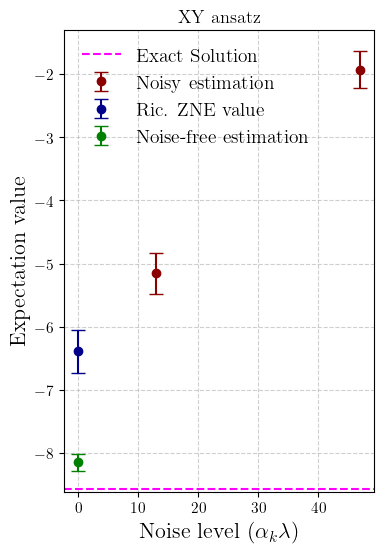

Figure saved as (in 'plots' folder): xy_ansatz_noise_free_tevo.eps


In [10]:
# Plot size
plt.figure(figsize=(4, 6))
# PLot name
plot_name: str= "xy_noisy_time_evo_ansatz_ric.eps"
# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=noisy_vqe_vals["xy"]["mean"],
    yerr=noisy_vqe_vals["xy"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=zne_vals["xy"]["mean"], 
    yerr=zne_vals["xy"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=noise_off_vqe_vals["xy"]["mean"], 
    yerr=noise_off_vqe_vals["xy"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["xy"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):", plot_export_names["xy"])

## (5) Summary

In [11]:
summary: dict={
    "noise-free-est":{
       "mean": noise_off_vqe_vals["xy"]["mean"],
       "std": noise_off_vqe_vals["xy"]["std"]
    },
    "noisy-est":{
        "mean": noisy_vqe_vals["xy"]["mean"],
        "std": noisy_vqe_vals["xy"]["std"]
    },
    "zne-est":{
        "mean": zne_vals["xy"]["mean"],
        "std": zne_vals["xy"]["std"]
    }
}

# Convert to a list of rows for tabulation
table_data = [
    [label, values["mean"], values["std"]]
    for label, values in summary.items()
]

# Define headers
headers = ["Estimate", "Mean", "Std Dev"]

# Print table
print(tabulate(table_data, headers=headers, floatfmt=".6f", tablefmt="grid"))

+----------------+-------------------------------------------+--------------------------------------------+
| Estimate       | Mean                                      | Std Dev                                    |
+================+===========================================+============================================+
| noise-free-est | -8.152227560716113                        | 0.13741793191711                           |
+----------------+-------------------------------------------+--------------------------------------------+
| noisy-est      | [-5.154676299758607, -1.9271617195200357] | [0.32388427113547413, 0.29480513114738105] |
+----------------+-------------------------------------------+--------------------------------------------+
| zne-est        | -6.388725992202764                        | 0.33929908828941757                        |
+----------------+-------------------------------------------+--------------------------------------------+
